In [19]:
import os
import io
import numpy as np
import torch
import torchaudio
import librosa
from azure.storage.blob import BlobServiceClient
from transformers import Wav2Vec2Processor, Wav2Vec2Model, BertTokenizer, BertModel
import logging
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

logging.basicConfig(level=logging.INFO)

# Load Data

In [24]:
import os
import io
import numpy as np
import torch
import torchaudio
from azure.storage.blob import BlobServiceClient
import logging
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

logging.basicConfig(level=logging.INFO)

def load_and_resample_audio(audio_data, target_sr=16000):
    waveform, sample_rate = torchaudio.load(io.BytesIO(audio_data))
    if sample_rate != target_sr:
        resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
        waveform = resampler(waveform)
    return waveform.squeeze().numpy()

def parse_filename(filename):
    parts = filename.split('-')
    modality_map = {'01': 'full-AV', '02': 'video-only', '03': 'audio-only'}
    vocal_channel_map = {'01': 'speech', '02': 'song'}
    emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
                   '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
    intensity_map = {'01': 'normal', '02': 'strong'}
    statement_map = {'01': "Kids are talking by the door", '02': "Dogs are sitting by the door"}
    
    return {
        'modality': modality_map[parts[0]],
        'vocal_channel': vocal_channel_map[parts[1]],
        'emotion': emotion_map[parts[2]],
        'emotional_intensity': intensity_map[parts[3]],
        'statement': statement_map[parts[4]],
        'repetition': int(parts[5]),
        'actor': int(parts[6]),
        'gender': 'male' if int(parts[6]) % 2 != 0 else 'female'
    }

def load_sample_from_blob(connection_string, container_name, sample_size=50, seed=42):
    random.seed(seed)
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    container_client = blob_service_client.get_container_client(container_name)

    all_blobs = list(container_client.list_blobs())
    total_blobs = len(all_blobs)
    
    if sample_size > total_blobs:
        logging.warning(f"Sample size {sample_size} is larger than total blobs {total_blobs}. Using all blobs.")
        sample_size = total_blobs
    
    sampled_blobs = random.sample(all_blobs, sample_size)

    data = []
    metadata = []
    processed_blobs = 0
    skipped_blobs = 0

    for blob in sampled_blobs:
        parts = blob.name.split('/')
        if len(parts) < 2:
            skipped_blobs += 1
            logging.warning(f"Skipping blob: {blob.name} - Invalid format")
            continue
        
        try:
            file_name = parts[-1]
            file_info = parse_filename(file_name.split('.')[0])  # Remove file extension
            
            blob_client = container_client.get_blob_client(blob)
            audio_data = blob_client.download_blob().readall()
            
            # Process audio
            audio = load_and_resample_audio(audio_data)
            
            data.append(audio)
            metadata.append(file_info)
            processed_blobs += 1
            
            if processed_blobs % 10 == 0:
                logging.info(f"Processed {processed_blobs}/{sample_size} blobs")
        except Exception as e:
            skipped_blobs += 1
            logging.error(f"Error processing blob: {blob.name} - {str(e)}")

    logging.info(f"Total blobs in container: {total_blobs}")
    logging.info(f"Sampled blobs: {sample_size}")
    logging.info(f"Processed blobs: {processed_blobs}")
    logging.info(f"Skipped blobs: {skipped_blobs}")

    return data, metadata

# Load a sample of the data
connection_string = "DefaultEndpointsProtocol=https;AccountName=emotiondevblob;AccountKey=kHZabJKdGLSbpJzFDv+4NJdc7oGvNZykoTLaxY3UfrX+uP3m8n0OFtDIGopUb/DeoDtxACl2GO8X+AStwDrUvw==;EndpointSuffix=core.windows.net"
container_name = "dev"
sample_size = 20  # Adjust this based on your needs and local resources

X, metadata = load_sample_from_blob(connection_string, container_name, sample_size=sample_size)

# Convert metadata to DataFrame for easier analysis
df_metadata = pd.DataFrame(metadata)

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://emotiondevblob.blob.core.windows.net/dev?restype=REDACTED&comp=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.21.0 Python/3.11.7 (macOS-14.5-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '5c8aae2e-4b78-11ef-b672-e6570c665222'
    'Authorization': 'REDACTED'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/xml'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '2ec2e890-b01e-004a-4685-df3374000000'
    'x-ms-client-request-id': '5c8aae2e-4b78-11ef-b672-e6570c665222'
    'x-ms-version': 'REDACTED'
    'Date': 'Fri, 26 Jul 2024 17:56:19 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:

Sample data size: 50

Metadata summary:
          modality vocal_channel emotion emotional_intensity  \
count           50            50      50                  50   
unique           1             1       6                   2   
top     audio-only          song   angry              normal   
freq            50            50      18                  25   
mean           NaN           NaN     NaN                 NaN   
std            NaN           NaN     NaN                 NaN   
min            NaN           NaN     NaN                 NaN   
25%            NaN           NaN     NaN                 NaN   
50%            NaN           NaN     NaN                 NaN   
75%            NaN           NaN     NaN                 NaN   
max            NaN           NaN     NaN                 NaN   

                           statement  repetition     actor gender  
count                             50   50.000000  50.00000     50  
unique                             2         NaN       

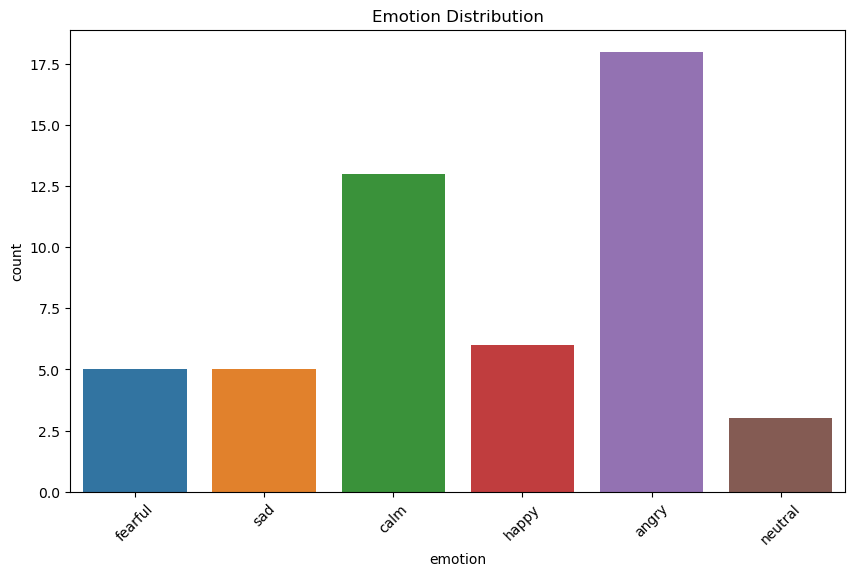

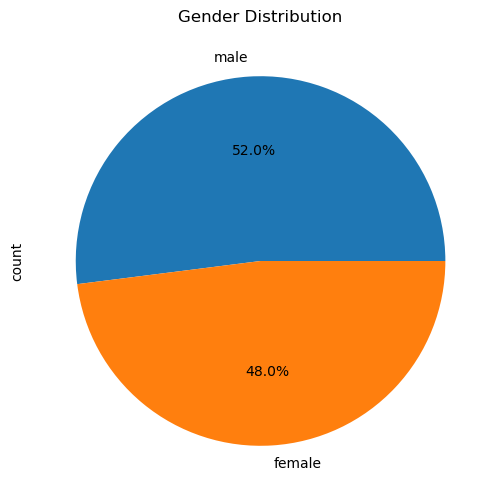

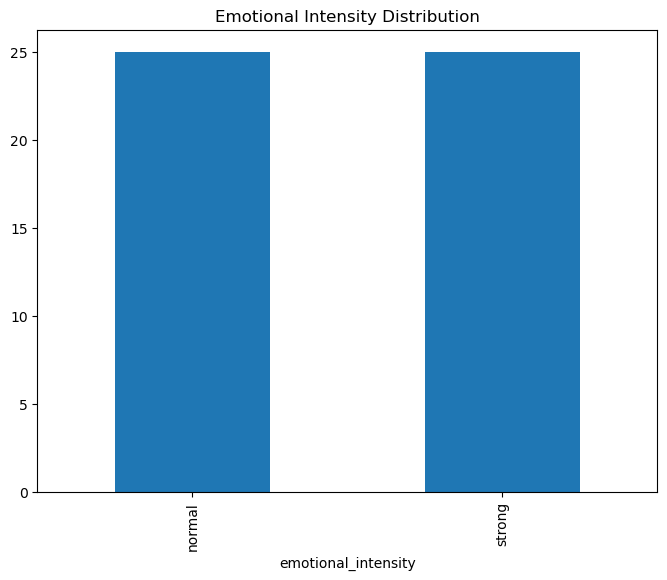

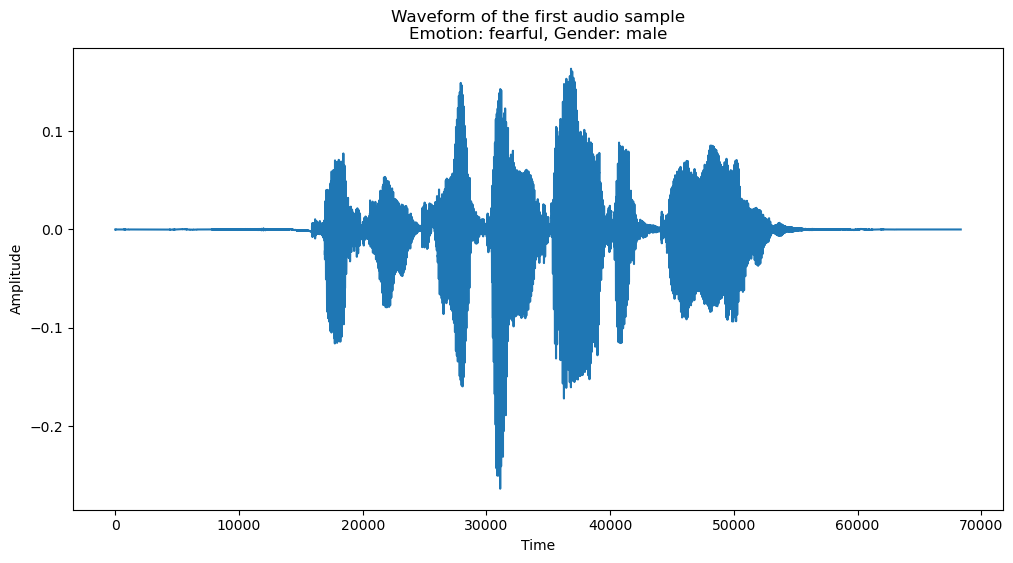

In [25]:
# Basic data exploration
print("Sample data size:", len(X))
print("\nMetadata summary:")
print(df_metadata.describe(include='all'))

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_metadata, x='emotion')
plt.title("Emotion Distribution")
plt.xticks(rotation=45)
plt.show()

# Visualize gender distribution
plt.figure(figsize=(8, 6))
df_metadata['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Gender Distribution")
plt.show()

# Visualize emotional intensity distribution
plt.figure(figsize=(8, 6))
df_metadata['emotional_intensity'].value_counts().plot(kind='bar')
plt.title("Emotional Intensity Distribution")
plt.show()

# Example of visualizing the first audio sample
plt.figure(figsize=(12, 6))
plt.plot(X[0])
plt.title(f"Waveform of the first audio sample\nEmotion: {df_metadata.iloc[0]['emotion']}, Gender: {df_metadata.iloc[0]['gender']}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Save

In [26]:
# Create a directory to store the data if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save the loaded data for feature engineering
for i, (audio, meta) in enumerate(zip(X, metadata)):
    np.save(f'data/audio_sample_{i}.npy', audio)

# Save the metadata
df_metadata.to_csv('data/metadata.csv', index=False)

# Save metadata (number of samples and their filenames)
metadata_summary = {
    'num_samples': len(X),
    'filenames': [f'audio_sample_{i}.npy' for i in range(len(X))]
}

with open('data/metadata_summary.pkl', 'wb') as f:
    pickle.dump(metadata_summary, f)

print("Data and metadata saved successfully.")

Data and metadata saved successfully.
